In [ ]:
import pandas as pd
import os

In [179]:
clients = os.listdir('NormalFL/fl_client/')
server  = os.listdir('NormalFL/fl_server/')

In [167]:
df['id'][0]

'7667f043cf814a7499cbc3f77706e238488b3ceaea9f8e41588111b1c279cace'

In [318]:
def get_memory_stats(df):
    memory_stats   = pd.json_normalize(df['memory_stats'])
    memory_results = pd.DataFrame()

    memory_results['used_memory']       = memory_stats['usage'] - memory_stats['stats.cache'] 
    memory_results['available_memory']  = memory_stats['limit']
    memory_results['percentage'] = (memory_results['used_memory'] / memory_results['available_memory']) * 100
    
    return memory_results

In [319]:
def get_cpu_stats(df):

    cpu_stats    = pd.json_normalize(df['cpu_stats'])
    precpu_stats = pd.json_normalize(df['precpu_stats'])

    cpu_results  = pd.DataFrame()
    cpu_results['cpu_delta']        = cpu_stats['cpu_usage.total_usage'] - precpu_stats['cpu_usage.total_usage']
    cpu_results['system_cpu_delta'] = cpu_stats['system_cpu_usage'] - precpu_stats['system_cpu_usage']
    cpu_results['num_cpus']         = cpu_stats['online_cpus']
    cpu_results['percentage']       = ( cpu_results['cpu_delta'] / cpu_results['system_cpu_delta']) * cpu_results['num_cpus'] * 100.0
    
    return cpu_results


In [320]:
def get_network_stats(df):
    network_stats = pd.json_normalize(df['networks'])
    
    return network_stats

In [391]:
def get_row_col(idx, length):
    
    row = int(idx/length)
    col = idx%length
    
    return row, col

# CPU and Memory Analysis per Client

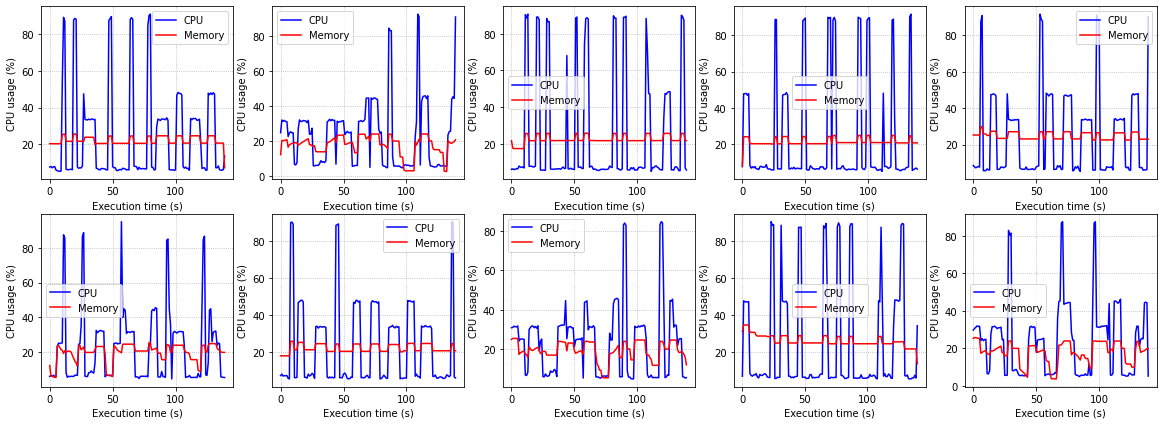

In [402]:
import matplotlib.pyplot as plt

clients = os.listdir('NormalFL/fl_client/')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 7))


for idx, client in enumerate(clients):
    df = pd.read_json(f'NormalFL/fl_client/{client}')
    
    row, col       = get_row_col(idx, 5)
    cpu_results    = get_cpu_stats(df)
    memory_results = get_memory_stats(df)
    
    cpu_results['percentage'].plot(ax=ax[row, col], color='blue', label='CPU')
    memory_results['percentage'].plot(ax=ax[row, col], color='red', label='Memory')
    
    ax[row, col].grid(True, linestyle=':')
    ax[row, col].set_xlabel('Execution time (s)')
    ax[row, col].set_ylabel('CPU usage (%)')
    ax[row, col].legend()   
    

# Aggregated CPU and Memory Analysis

In [377]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

clients     = os.listdir('NormalFL/fl_client/')
average_cpu = pd.DataFrame()
average_ram = pd.DataFrame()

for idx, client in enumerate(clients):
    df = pd.read_json(f'NormalFL/fl_client/{client}')
    
    cpu_results = get_cpu_stats(df)
    ram_results = get_memory_stats(df)
    
    average_cpu = average_cpu.append(cpu_results)
    average_ram = average_ram.append(ram_results)

## PDF Plots

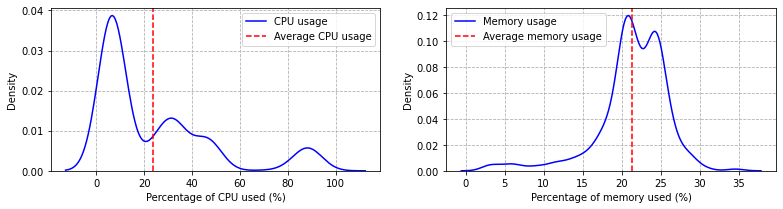

In [397]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 3))

sns.kdeplot(average_cpu['percentage'].values, ax=ax[0], color='blue', label='CPU usage')
ax[0].axvline(average_cpu['percentage'].mean(), color='red', linestyle='--', label='Average CPU usage')
ax[0].legend()
ax[0].set_xlabel('Percentage of CPU used (%)')
ax[0].grid(True, linestyle='--')

sns.kdeplot(average_ram['percentage'].values, ax=ax[1], color='blue', label='Memory usage')
ax[1].axvline(average_ram['percentage'].mean(), color='red', linestyle='--', label='Average memory usage')
ax[1].legend()
ax[1].set_xlabel('Percentage of memory used (%)')
ax[1].grid(True, linestyle='--')

## CDF Plots

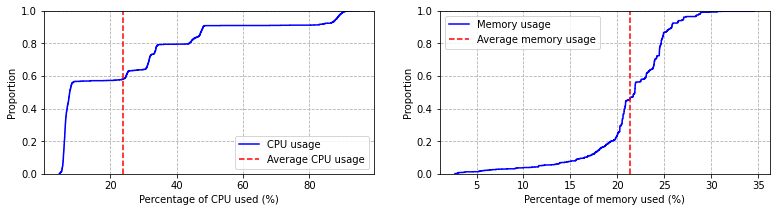

In [387]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 3))

sns.ecdfplot(average_cpu['percentage'].values, ax=ax[0], color='blue',label='CPU usage')
ax[0].axvline(average_cpu['percentage'].mean(), color='red', linestyle='--', label='Average CPU usage')
ax[0].set_xlabel('Percentage of CPU used (%)')
ax[0].grid(True, linestyle='--')
ax[0].legend()

sns.ecdfplot(average_ram['percentage'].values, ax=ax[1], color='blue', label='Memory usage')
ax[1].axvline(average_ram['percentage'].mean(), color='red', linestyle='--', label='Average memory usage')
ax[1].set_xlabel('Percentage of memory used (%)')
ax[1].grid(True, linestyle='--')
ax[1].legend()

# Network Analysis

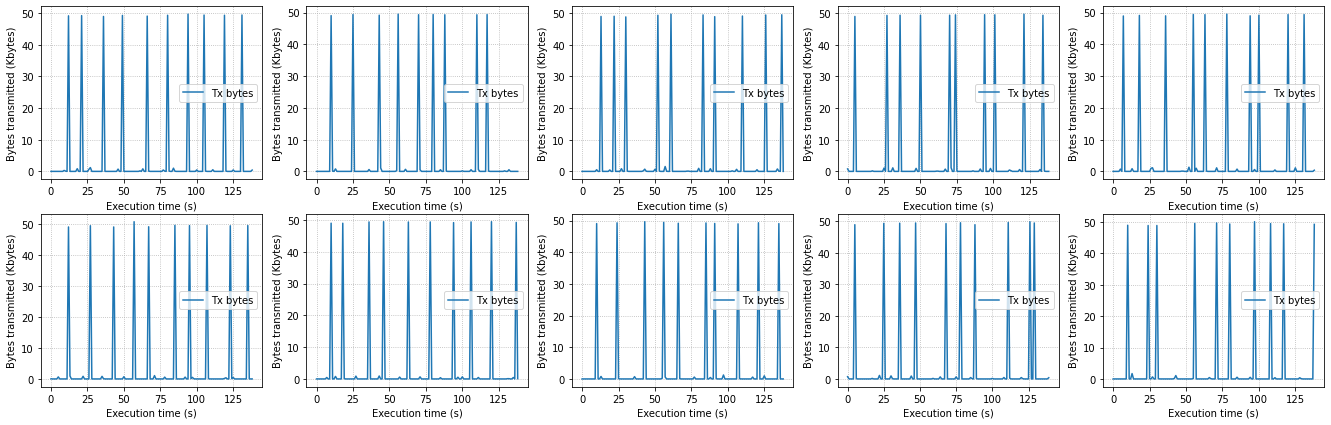

In [558]:
import matplotlib.pyplot as plt

clients = os.listdir('NormalFL/fl_client/')
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(23, 7))

average_results  = pd.DataFrame()

for idx, client in enumerate(clients):
    df = pd.read_json(f'NormalFL/fl_client/{client}')
    
    row, col         = get_row_col(idx, 5)
    network_results  = get_network_stats(df)
    tx_bytes         = []
    rx_bytes         = []
    tx_packetes      = []
    
    for _ in range(1, len(network_results)):
        tx_bytes.append(network_results['eth0.tx_bytes'][_] - network_results['eth0.tx_bytes'][_ - 1])
        tx_packetes.append(network_results['eth0.tx_packets'][_] - network_results['eth0.tx_packets'][_ - 1])
        rx_bytes.append(network_results['eth0.rx_bytes'][_] - network_results['eth0.rx_bytes'][_ - 1])
    
    temp_df               = pd.DataFrame()
    temp_df['timestamp']  = list(range(len(tx_bytes)))
    temp_df['tx_bytes']   = np.array(tx_bytes)/1_000
    temp_df['tx_packets'] = tx_packetes
    temp_df['rx_bytes']   = rx_bytes
    temp_df['user']       = idx
    average_results       = average_results.append(temp_df)  
    

    ax[row, col].plot(range(len(tx_bytes)), np.array(tx_bytes)/1_000, label='Tx bytes')
    
    ax[row, col].grid(True, linestyle=':')
    ax[row, col].set_xlabel('Execution time (s)')
    ax[row, col].set_ylabel('Bytes transmitted (Kbytes)')
    ax[row, col].legend()

# Aggregated Network Analysis

In [559]:
average_results = average_results.dropna()
average_results.reset_index(inplace=True)

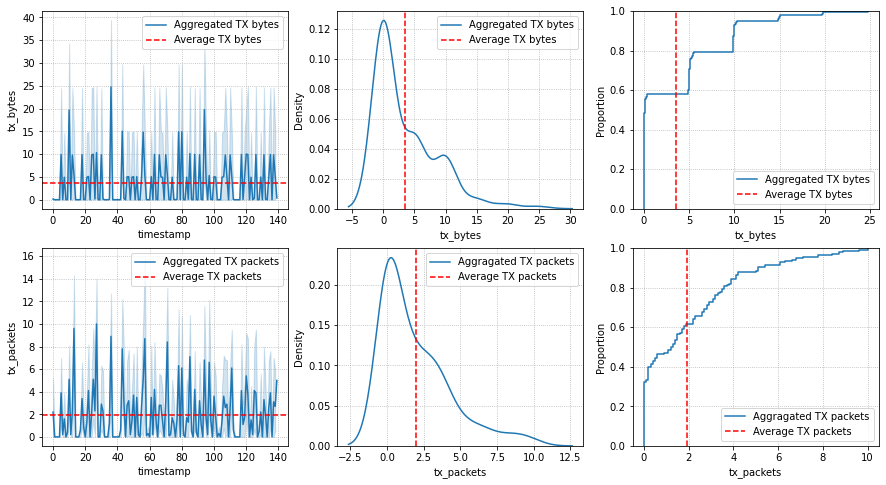

In [572]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

mean_user = average_results.groupby('user').mean()
mean_step = average_results.groupby('timestamp').mean()

sns.lineplot(x='timestamp', y='tx_bytes', data=average_results, ax=ax[0,0], label='Aggregated TX bytes')
ax[0, 0].grid(True, linestyle=':')
ax[0, 0].axhline(np.mean(average_results['tx_bytes'].values), color='r', linestyle='--', label='Average TX bytes')
ax[0, 0].legend()

sns.kdeplot(x='tx_bytes', data=mean_step, ax=ax[0,1], label='Aggregated TX bytes')
ax[0, 1].grid(True, linestyle=':')
ax[0, 1].axvline(np.mean(mean_step['tx_bytes'].values), color='r', linestyle='--', label='Average TX bytes')
ax[0, 1].legend()

sns.ecdfplot(x='tx_bytes', data=mean_step, ax=ax[0, 2], label='Aggregated TX bytes')
ax[0, 2].grid(True, linestyle=':')
ax[0, 2].axvline(np.mean(mean_step['tx_bytes'].values), color='r', linestyle='--', label='Average TX bytes')
ax[0, 2].legend()

sns.lineplot(x='timestamp', y='tx_packets', data=average_results, ax=ax[1,0], label='Aggregated TX packets')
ax[1, 0].grid(True, linestyle=':')
ax[1, 0].axhline(np.mean(average_results['tx_packets'].values), color='r', linestyle='--', label='Average TX packets')
ax[1, 0].legend()

sns.kdeplot(x='tx_packets', data=mean_step, ax=ax[1,1], label='Aggragated TX packets')
ax[1, 1].grid(True, linestyle=':')
ax[1, 1].axvline(np.mean(mean_step['tx_packets'].values), color='r', linestyle='--', label='Average TX packets')
ax[1, 1].legend()

sns.ecdfplot(x='tx_packets', data=mean_step, ax=ax[1, 2], label='Aggragated TX packets')
ax[1, 2].grid(True, linestyle=':')
ax[1, 2].axvline(np.mean(mean_step['tx_packets'].values), color='r', linestyle='--', label='Average TX packets')

ax[1, 2].legend()

<AxesSubplot:xlabel='timestamp', ylabel='user'>

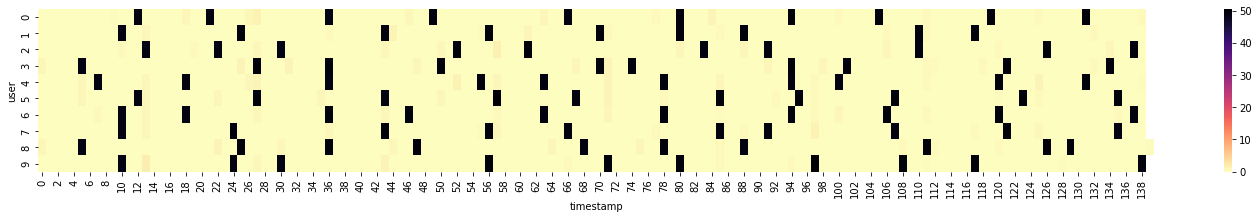

In [588]:
fig, ax = plt.subplots(figsize=(25, 3))

sns.heatmap(average_results.pivot("user", "timestamp", "tx_bytes"), cmap='magma_r', ax=ax)